In [ ]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
!pip install prophet
!pip install NeuralProphet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation

from neuralprophet import NeuralProphet, set_log_level

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import the 5 years of hourly energy consumption data already #cleaned and feature engineer 
url = "https://raw.githubusercontent.com/pratha19/Hourly_Energy_Consumption_Prediction/master/hourly1418_energy_temp_PV.csv"
df = pd.read_csv(url,usecols=['Dates','SDGE'], parse_dates=['Dates'])
df.columns = ['ds','y']

df.head()

,ds,y
0,2014-01-01 00:00:00,2096.0
1,2014-01-01 01:00:00,1986.0
2,2014-01-01 02:00:00,1936.0
3,2014-01-01 03:00:00,1896.0
4,2014-01-01 04:00:00,1899.0


In [ ]:
#taking 1 yr of data only as 
# 5 yr data was 2hr+ time on cross_validation while comparing which leads to difficulty in hyperparameter tuning
df=df.drop(range(2500,43824))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2500 non-null   datetime64[ns]
 1   y       2500 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 58.6 KB


In [ ]:
fig = px.scatter(df, x='ds', y='y', title='HECP', template='simple_white')
fig.show()

In [ ]:
###########################
# Data + helpers
###########################

def accuracy(obs, pred):
    """
    Calculate accuracy measures
    :param obs: pd.Series of observed values
    :param pred: pd.Series of forecasted values
    :return: dict with accuracy measures
    """

    obs, pred = np.array(obs.dropna()), np.array(pred.dropna())

    assert len(obs) == len(pred), f'accuracy(): obs len is {len(obs)} but preds len is {len(pred)}'

    rmse = np.sqrt(np.mean((obs - pred)**2))
    mape = np.mean(np.abs((obs - pred) / obs)) 

    return (rmse, mape)

###########################
# Prophet (v1) 
###########################
# base code from docs on Prophet
def fit_prophet(df):
    """
    Fit Prophet model and return 
    """

    # fit model
    m = Prophet()
    m.fit(df)

    # create forecast
    future = m.make_future_dataframe(periods=375,freq='H')
    forecast = m.predict(future)

    # create plots
    pred_plot = plot_plotly(m, forecast)
    comp_plot = plot_components_plotly(m, forecast)

    return (m, forecast, pred_plot, comp_plot)

def eval_prophet(m):
    """
    Perform CV on data and evaluate. Note TS CV differs from regular CV.
    IMPORTANT: this is correct eval method according to the docs, but differs from NeuralProphet 
               so I built a custom function.
    """
    #1. 1 to 750 will forcast 750+375  
    #2. 188 to 750+188 will forcast 750+375+375
    # .
    # .
    # .
    # .
    df_cv = cross_validation(m, initial='750 hours', period='188 hours', horizon = '375 hours')

    return (df_cv, performance_metrics(df_cv))


###########################
# NeuralProphet (v2) 
###########################
# base code from docs on NeuralProphet
def fit_neural(df, params=None):
    """
    FIt NeuralProphet and return key objects.
    """

    # fit 
    m = NeuralProphet(**params) if params is not None else NeuralProphet()
    metrics = m.fit(df, freq="H")

    df_future = m.make_future_dataframe(df, periods=375)
    forecast = m.predict(df_future, raw=True, decompose=False) if params is not None else m.predict(df_future)

    if params is None:
        fig_forecast = m.plot(forecast)
        fig_components = m.plot_components(forecast)
        fig_params = m.plot_parameters()

        return (m, forecast, fig_forecast, fig_components, fig_params) 

    else:
        return (None, forecast, None, None)

def eval_neural(df):
    """
    Perform cross validation on our model.
    IMPORTANT: this is correct eval method according to the docs, but differs from Prophet 
               so I built a custom function.
    """

    # setup k fold CV
    METRICS = ['SmoothL1Loss', 'MAE', 'RMSE']
    # freq=H is for hourly
    # folds=5
    # fold percentage 20
    # fold overlap percent = 50
    folds = NeuralProphet().crossvalidation_split_df(df, freq="H", k=5, fold_pct=0.20, fold_overlap_pct=0.5)

    # return dfs
    metrics_train = pd.DataFrame(columns=METRICS)
    metrics_test = pd.DataFrame(columns=METRICS)

    # CV
    for df_train, df_test in folds:
        m = NeuralProphet()
        train = m.fit(df=df_train, freq="H")
        test = m.test(df=df_test)
        metrics_train = metrics_train.append(train[METRICS].iloc[-1])
        metrics_test = metrics_test.append(test[METRICS].iloc[-1])

    return (metrics_train, metrics_test)

###########################
# All in One Function
###########################
def cv_run_both_models(df, neural_params):
    """
    Create a CV dataset and run both models and return accuracies. Note that both models
    have their own eval methods, but they differ so I built a custom func that does the 
    same thing. 
    :param df: pd.DataFrame of Prophet-specified format
    :param neural_params: dict of params to be passed to NeuralProphet
    :return: tuple of training accuracies
    """

    # create train test splits (test = 375 hours, train = all prior data, increment = 188 hours)
    # [750, 938, 1126, 1314, 1502, 1690, 1878, 2066]
    train_test_split_indices = list(range(375*2, len(df.index) - 375, 188))
    train_test_splits = [(df.iloc[:i, :], df.iloc[i:(i+375), :]) for i in train_test_split_indices]

    rmse_p, mape_p = [], []
    rmse_n, mape_n = [], []
    n_training_hours = []

    # loop through train/test splits
    for x in train_test_splits:
        train, test = x
        n_training_hours.append(len(train.index))

        # train Prophet and get accuracy 
        _, forecast, *_ = fit_prophet(train)
        rmse, mape = accuracy(test['y'], forecast.loc[test['y'].index, 'yhat'])
        rmse_p.append(rmse)
        mape_p.append(mape)

        # train NeuralProphet and get accuracy 
        _, forecast, *_ = fit_neural(train, neural_params)
        rmse, mape = accuracy(test['y'], pd.Series(np.array(forecast.iloc[:, 1:]).flatten()))
        rmse_n.append(rmse)
        mape_n.append(mape)

    return pd.DataFrame(dict(
        n_training_hours=n_training_hours,
        prophet_RMSE=rmse_p,
        neural_RMSE=rmse_n,
        prophet_MAPE=mape_p,
        neural_MAPE=mape_n
    ))






In [ ]:
########## Prophet ###############
# fit model and store output

m1, forecast1, forecast_plot1, component_plot1 = fit_prophet(df)
cv_df, prophet_accuracy_df = eval_prophet(m1)
# show plots
forecast_plot1.show()
component_plot1.show()
print(prophet_accuracy_df.describe())

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 8 forecasts with cutoffs between 2014-02-03 16:00:00 and 2014-03-30 12:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

                         horizon           mse        rmse         mae  \
count                        338    338.000000  338.000000  338.000000   
mean             8 days 14:30:00  13303.062866  114.359001   87.840496   
std    4 days 01:42:59.135253926   3508.038180   15.024964   10.964271   
min              1 days 14:00:00   8153.418639   90.296283   68.454955   
25%              5 days 02:15:00  10017.340167  100.086660   78.107665   
50%              8 days 14:30:00  12886.876183  113.520259   87.745808   
75%             12 days 02:45:00  16458.187536  128.289395   97.277458   
max             15 days 15:00:00  21608.011990  146.996639  109.590791   

             mape       mdape       smape    coverage  
count  338.000000  338.000000  338.000000  338.000000  
mean     0.039744    0.030781    0.039576    0.738925  
std      0.004775    0.004306    0.004740    0.046645  
min      0.031008    0.022532    0.030845    0.648333  
25%      0.035320    0.027543    0.035271    0.698750

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.96% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.96% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 148
INFO:NP.config:Auto-set epochs to 148


  0%|          | 0/135 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.20E-01, min: 1.32E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.20E-01, min: 1.32E+00


  0%|          | 0/135 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-01, min: 2.85E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.46E-01, min: 2.85E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.85E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.85E-01
Epoch[148/148]: 100%|██████████| 148/148 [00:27<00:00,  5.41it/s, SmoothL1Loss=0.00382, MAE=78.1, RMSE=99.5, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.96% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.96% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.733% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.733% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to 

  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.75E-02, min: 1.34E+00
INFO:NP.utils_torch:lr-range-test results: steep: 5.75E-02, min: 1.34E+00


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.79E-02, min: 1.34E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.79E-02, min: 1.34E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.31E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 7.31E-02
Epoch[194/194]: 100%|██████████| 194/194 [00:16<00:00, 11.59it/s, SmoothL1Loss=0.00254, MAE=67.1, RMSE=84.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.8% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.006 105.766 131.767
INFO:NP.forecaster:Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.006 105.766 131.767
INFO - (NP.df_u

  0%|          | 0/128 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.97E-02, min: 1.22E+00
INFO:NP.utils_torch:lr-range-test results: steep: 8.97E-02, min: 1.22E+00


  0%|          | 0/128 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.97E-02, min: 1.22E+00
INFO:NP.utils_torch:lr-range-test results: steep: 8.97E-02, min: 1.22E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.30E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 9.30E-02
Epoch[181/181]: 100%|██████████| 181/181 [00:19<00:00,  9.34it/s, SmoothL1Loss=0.0024, MAE=64.8, RMSE=82.3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.8% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.003 72.113 95.724
INFO:NP.forecaster:Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.003 72.113 95.724
INFO - (NP.df_utils._inf

  0%|          | 0/130 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 1.80E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.00E-01, min: 1.80E+00


  0%|          | 0/130 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.62E-01, min: 1.53E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.62E-01, min: 1.53E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.17E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.17E-01
Epoch[171/171]: 100%|██████████| 171/171 [00:20<00:00,  8.45it/s, SmoothL1Loss=0.00255, MAE=66.2, RMSE=84.4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.8% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE    RMSE
1         0.005 90.178 121.317
INFO:NP.forecaster:Validation metrics:    SmoothL1Loss    MAE    RMSE
1         0.005 90.178 121.317
INFO - (NP.df_utils

  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.99E-02, min: 1.15E+00
INFO:NP.utils_torch:lr-range-test results: steep: 8.99E-02, min: 1.15E+00


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.54E-02, min: 1.35E+00
INFO:NP.utils_torch:lr-range-test results: steep: 6.54E-02, min: 1.35E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.38E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 8.38E-02
Epoch[164/164]: 100%|██████████| 164/164 [00:21<00:00,  7.68it/s, SmoothL1Loss=0.00266, MAE=67.4, RMSE=85.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.8% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE    RMSE
1         0.005 95.272 118.340
INFO:NP.forecaster:Validation metrics:    SmoothL1Loss    MAE    RMSE
1         0.005 95.272 118.340
INFO - (NP.df_utils

  0%|          | 0/133 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 1.97E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.00E-01, min: 1.97E+00


  0%|          | 0/133 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.70E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.00E-01, min: 2.70E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.00E-01
Epoch[158/158]: 100%|██████████| 158/158 [00:24<00:00,  6.54it/s, SmoothL1Loss=0.00299, MAE=70.7, RMSE=89.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.8% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.008 107.363 145.219
INFO:NP.forecaster:Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.008 107.363 145.219


       SmoothL1Loss        MAE       RMSE
count      5.000000   5.000000   5.000000
mean       0.002629  67.243419  85.401243
std        0.000221   2.186712   2.688887
min        0.002402  64.771090  82.307977
25%        0.002538  66.237386  84.446737
50%        0.002552  67.126697  84.842630
75%        0.002664  67.378679  85.765413
max        0.002988  70.703246  89.643460
       SmoothL1Loss         MAE        RMSE
count      5.000000    5.000000    5.000000
mean       0.005414   94.138428  122.473436
std        0.001652   14.249236   18.287339
min        0.003192   72.113129   95.723907
25%        0.004961   90.178047  118.339882
50%        0.005153   95.272392  121.317047
75%        0.006049  105.765930  131.767014
max        0.007716  107.362640  145.219330


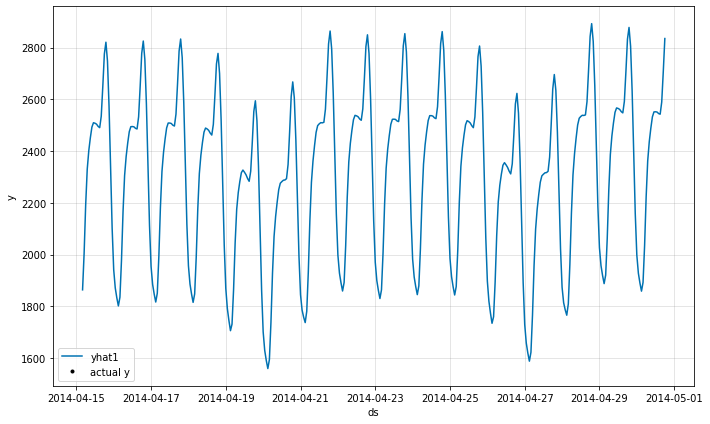

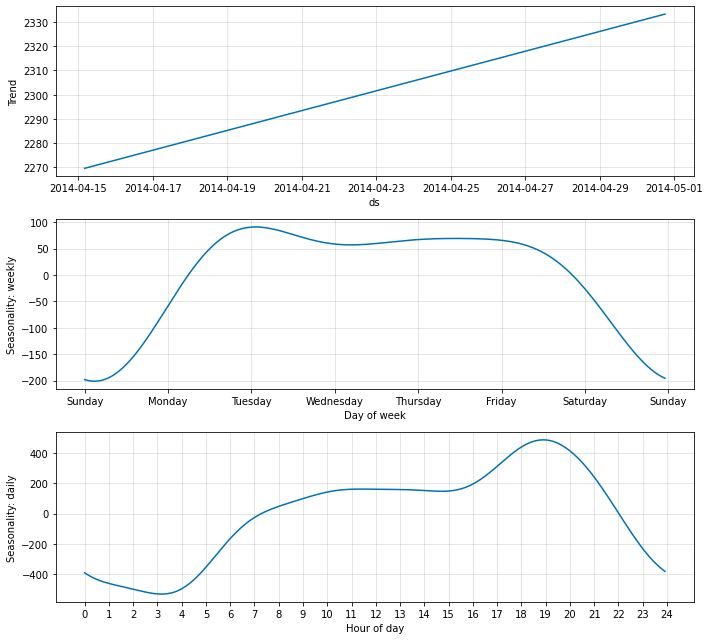

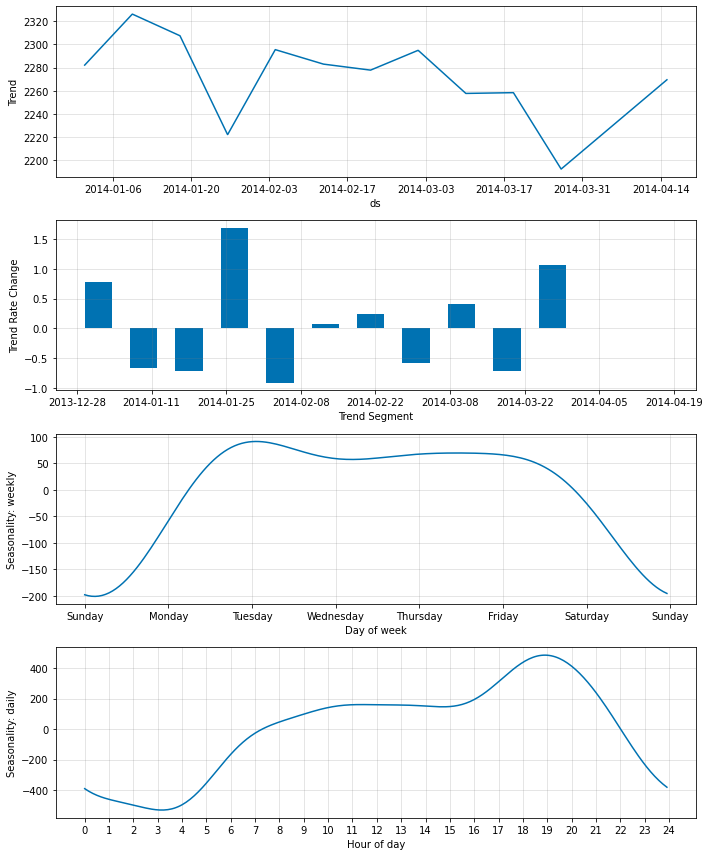

In [ ]:
########## Neural Prophet ##########
# fit model and store output

m2, forecast2, forecast_plot2, component_plot2, params_plot2 = fit_neural(df)
metrics_train, metrics_test = eval_neural(df)
print(metrics_train.describe())
print(metrics_test.describe())
plt.show()


In [33]:

############# Both Models' Training Accuracy ##########
# set model parameters to use AR-Net

# I have tried using these parameters and tune model for best accuracy 

neural_params =  dict(

    #feeds 400 lags into AR-Net and receives 375 (same as future periods)steps as forecast
    # The value for n_lags is usually recommended to be greater than n_forecasts
    #n_forecasts=375,
    # #past observations to regress over
    #n_lags=400,
    #not able to tune these parameters as it is giving error


    #Number of potential changepoints to include.
    # increase the changepoints_range, as the we are doing a short-term prediction 
    #* inrease the n_changepoints to allow to fit to the sudden changes in trend
    n_changepoints=30,
  
    changepoints_range=0.95,

    # #NeuralProphet fits any seasonality that is possible with the data (can be changed according to fourier terms)
    # # energy consumption seasonality could be there in any of 2
     yearly_seasonality=False,
    # weekly_seasonality=True,
    # daily_seasonality=True,

    # #model was bit overfitting to the training data , 
    # #so reduced epochs and learning_rate, and  increased the batch_size

    # #The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
    # 
     batch_size=64,
     epochs=100,
    # #number times that the learning algorithm works
     
     learning_rate=0.01,

     # trend changepoints by setting trend_reg in order to avoid overfitting

     trend_reg=5
)
out = cv_run_both_models(df, neural_params)
print(out)



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO:NP.config:Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.867% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.867% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
Epoch[100/100]: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s, SmoothL1Loss=0.00469, MAE=86.5, RMSE=115, RegLoss=0.0377]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.867% of

   n_training_hours  prophet_RMSE  neural_RMSE  prophet_MAPE  neural_MAPE
0               750    129.966608   107.709235      0.046154     0.037191
1               938    115.550602    85.749903      0.044395     0.030939
2              1126     87.653257    88.423692      0.031257     0.031049
3              1314     90.976967   104.853184      0.032837     0.037944
4              1502    106.263615   100.127693      0.037491     0.034236
5              1690    113.956095   112.015614      0.038043     0.036403
6              1878    118.618594   183.751876      0.037718     0.073918
7              2066    146.447115   353.256182      0.046953     0.138742
